In [1]:
DATAPATH = '../data/'
XFERPATH = '~/gdrive_files/twitgen/'  # To transfer files from Google Colab
TRAIN_FNAME = 'embed_train_201906020021.csv'
VALID_FNAME = 'embed_valid_201906020021.csv'
TEST_FNAME = 'embed_test_201906020021.csv'
ELMO_TRAIN_FNAME = 'elmo_embed_train_201906031137.csv'
ELMO_VALID_FNAME = 'elmo_embed_valid_201906031137.csv'
ELMO_TEST_FNAME = 'elmo_embed_test_201906031137.csv'
MODEL_TYPE_ID = 'lrpe'

In [9]:
train_from = XFERPATH + TRAIN_FNAME
valid_from = XFERPATH + VALID_FNAME
test_from = XFERPATH + TEST_FNAME
elmo_train_from = XFERPATH + ELMO_TRAIN_FNAME
elmo_valid_from = XFERPATH + ELMO_VALID_FNAME
elmo_test_from = XFERPATH + ELMO_TEST_FNAME
!cp $train_from $DATAPATH
!cp $valid_from $DATAPATH
!cp $test_from $DATAPATH
!cp $elmo_train_from $DATAPATH
!cp $elmo_valid_from $DATAPATH
!cp $elmo_test_from $DATAPATH

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from datetime import datetime

In [11]:
timestamp = datetime.now().strftime('%Y%m%d%H%M')
timestamp

'201906041738'

In [44]:
df_train = pd.read_csv(DATAPATH+TRAIN_FNAME, index_col=[0,1], parse_dates=['time'])
df_valid = pd.read_csv(DATAPATH+VALID_FNAME, index_col=[0,1], parse_dates=['time'])
df_test = pd.read_csv(DATAPATH+TEST_FNAME, index_col=[0,1], parse_dates=['time'])
df_train.head().iloc[:,:7]

,,male,embed0,embed1,embed2,embed3,embed4,embed5
id,time,,,,,,,
1083596943807393792,2019-05-27 23:27:08+00:00,True,-14081,80216,26727,19969,-5932,14983
815783987784187904,2019-05-24 15:36:01+00:00,False,-8092,-61741,24805,-21488,-20012,6800
3458239641,2019-05-24 19:00:37+00:00,False,-47872,-23766,28058,63213,9773,31955
1003729876250226688,2019-05-26 12:53:00+00:00,True,-16403,68003,17321,110208,4481,-44518
2360143940,2019-05-28 03:50:46+00:00,False,-11004,-11367,-47373,58910,31987,-48830


In [35]:
print(df_train.shape, df_valid.shape, df_test.shape)
print(df_train.index.get_level_values(1).min(), df_train.index.get_level_values(1).max())
print(df_valid.index.get_level_values(1).min(), df_valid.index.get_level_values(1).max())
print(df_test.index.get_level_values(1).min(), df_test.index.get_level_values(1).max())

(34146, 513) (10914, 513) (10450, 513)
2019-05-21 17:50:48+00:00 2019-05-28 12:44:26+00:00
2019-05-28 12:44:27+00:00 2019-05-30 12:09:54+00:00
2019-05-30 12:10:02+00:00 2019-06-01 19:55:43+00:00


In [14]:
df_train_elmo = pd.read_csv(DATAPATH+ELMO_TRAIN_FNAME, index_col=[0,1], parse_dates=['time'])
df_valid_elmo = pd.read_csv(DATAPATH+ELMO_VALID_FNAME, index_col=[0,1], parse_dates=['time'])
df_test_elmo = pd.read_csv(DATAPATH+ELMO_TEST_FNAME, index_col=[0,1], parse_dates=['time'])
df_train_elmo.head().iloc[:,:7]

,,male,embed0,embed1,embed2,embed3,embed4,embed5
id,time,,,,,,,
1083596943807393792,2019-05-27 23:27:08+00:00,True,49360,-201511,49796,-223839,-194562,-13944
815783987784187904,2019-05-24 15:36:01+00:00,False,-150333,-739523,212058,24423,490195,146718
3458239641,2019-05-24 19:00:37+00:00,False,-441721,-647246,178979,-54673,243166,330631
1003729876250226688,2019-05-26 12:53:00+00:00,True,-304138,-195058,119782,-40389,10654,263431
2360143940,2019-05-28 03:50:46+00:00,False,-331281,52667,-29711,-42573,55504,111023


In [15]:
print(df_train_elmo.shape, df_valid_elmo.shape, df_test_elmo.shape)
print(df_train_elmo.index.get_level_values(1).min(), df_train_elmo.index.get_level_values(1).max())
print(df_valid_elmo.index.get_level_values(1).min(), df_valid_elmo.index.get_level_values(1).max())
print(df_test_elmo.index.get_level_values(1).min(), df_test_elmo.index.get_level_values(1).max())

(34146, 1025) (10914, 1025) (10450, 1025)
2019-05-21 17:50:48+00:00 2019-05-28 12:44:26+00:00
2019-05-28 12:44:27+00:00 2019-05-30 12:09:54+00:00
2019-05-30 12:10:02+00:00 2019-06-01 19:55:43+00:00


In [150]:
df_train.drop(['male'],axis=1).mean().mean()

246.14952417102285

In [151]:
df_train_elmo.drop(['male'],axis=1).mean().mean()

5166.507796083822

In [242]:
scaledown = 300
df_train_final = df_train.join(df_train_elmo.drop(['male'],axis=1)/scaledown, rsuffix='elmo')
df_valid_final = df_valid.join(df_valid_elmo.drop(['male'],axis=1)/scaledown, rsuffix='elmo')
df_test_final = df_test.join(df_test_elmo.drop(['male'],axis=1)/scaledown, rsuffix='elmo')
df_train_final.shape, df_valid_final.shape, df_test_final.shape

((34210, 1537), (10926, 1537), (10468, 1537))

In [243]:
def getxy(df):
    X = df.drop(['male'],axis=1).values / 1e6
    y = 1*df.male.values
    return(X, y)
    
X_train, y_train = getxy(df_train_final)
X_valid, y_valid = getxy(df_valid_final)
X_test, y_test = getxy(df_test_final)

In [244]:
pca = PCA(64)
pca.fit(X_train)
print(pca.explained_variance_ratio_)

[0.07031543 0.04057424 0.03005203 0.02582    0.02313349 0.02283584
 0.02030099 0.01948385 0.01809179 0.01758546 0.01700242 0.01580986
 0.0150036  0.01433222 0.01404797 0.01360169 0.01325036 0.01278479
 0.01204377 0.01198104 0.01168749 0.01145789 0.0110352  0.01082165
 0.01029283 0.01027374 0.00977921 0.00967842 0.00925725 0.00904362
 0.00876148 0.00859131 0.00854967 0.00834077 0.00828749 0.00798252
 0.0078537  0.0076541  0.00749549 0.00747463 0.00722636 0.00710821
 0.0070048  0.00689482 0.00681088 0.00663747 0.00655006 0.00637017
 0.00632268 0.00625307 0.00620418 0.0060421  0.00593307 0.00588857
 0.00584804 0.00578586 0.00572836 0.0056636  0.00550545 0.00539033
 0.00531573 0.00528813 0.00519571 0.0051181 ]


In [299]:
model = Pipeline([('pca',  PCA(50)),
                  ('poly', PolynomialFeatures()),
                  ('lr',   LogisticRegression(C=.08))])
model = model.fit(X_train, y_train)

/Users/andy/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [300]:
def save_predictions(df, predictions, which_set):
    pred_df = df[['male']].copy()
    pred_df['pred'] = predictions
    path = DATAPATH + MODEL_TYPE_ID + '_' + which_set + '_pred_' + timestamp + '.csv'
    pred_df.to_csv(path)    

In [301]:
y_train_pred = model.predict_proba(X_train)[:,1]
save_predictions(df_train_final, y_train_pred, 'train')
f1_score(y_train, y_train_pred>.5)

0.7001133622067842

In [302]:
y_pred = model.predict_proba(X_valid)[:,1]
save_predictions(df_valid_final, y_pred, 'valid')
print( confusion_matrix(y_valid, (y_pred>.5)) )
f1_score(y_valid, y_pred>.5)

[[3325 2134]
 [1880 3587]]


0.6412227386485521

In [249]:
64 6371
55 6379
50 6400, 6412
48 6392
45 6401
40 6394

.1 6373
.08 6403
.05 6396
.04 6396
.01 6380
.005 6378

# 6390 @10
# 6378 @100
# 6362 @20
# 6364 @5
# 6395 @1000
# 6415, 6397, 6398 @500  6398
# 6414, 6400, 6436 @400  6414 6400
# 6392, 6406, 6378 @350  6392 6406
# 6420, 6403, 6415, 6410 @300  6415 6406
# 6413, 6392, 6409 @250  6409 6408
# 6408, 6393, 6397 @200  6397

In [303]:
accuracy_score(y_valid, y_pred>.5)

0.6326194398682042

In [ ]:
# 6306, 6315 # 500
# 6332, 6314, 6339 @ 400
# 6317, 6326, 6297 @ 350
# 6322, 6329, 6328 @ 300
# 6329, 6312, 6329 @250
# 6309, 6311 # 200

In [304]:
y_test_pred = model.predict_proba(X_test)[:,1]
save_predictions(df_test_final, y_test_pred, 'test')
print( confusion_matrix(y_test, (y_test_pred>.5)) )
f1_score(y_test, y_test_pred>.5)

[[3126 2109]
 [1869 3364]]


0.6284326545862133

In [305]:
accuracy_score(y_test, y_test_pred>.5)

0.6199847153228888

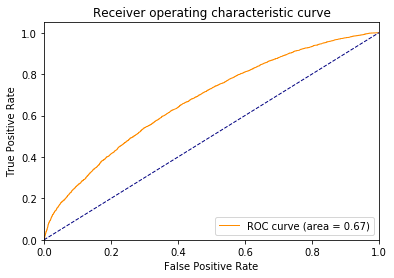

In [306]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

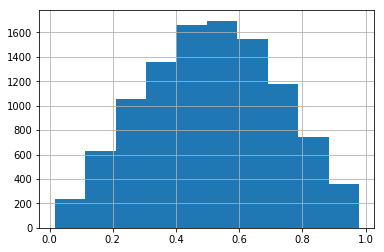

In [307]:
pd.Series(y_test_pred).hist()
plt.show()

In [308]:
df_acc = pd.DataFrame(columns=['minprob','maxprob','count','accuracy'])
for pbot in np.linspace(0,.9,10):
    ptop = pbot+.1
    mask = (y_test_pred>=pbot)&(y_test_pred<ptop)
    count = int(mask.sum())
    acc = accuracy_score(y_test[mask], y_test_pred[mask]>.5)
    row = pd.DataFrame({'minprob':[pbot], 'maxprob':[ptop], 'count':[count], 'accuracy':[acc]})
    df_acc = pd.concat([df_acc, row])
df_acc.set_index(['minprob','maxprob'])

,,count,accuracy
minprob,maxprob,,
0.0,0.1,194,0.881443
0.1,0.2,596,0.768456
0.2,0.3,1070,0.682243
0.3,0.4,1403,0.600143
0.4,0.5,1732,0.534065
0.5,0.6,1743,0.517499
0.6,0.7,1599,0.592245
0.7,0.8,1138,0.633568
0.8,0.9,723,0.780083


In [19]:
from joblib import dump
model_path = DATAPATH + MODEL_TYPE_ID + '_model_' + timestamp + '.joblib'
dump(model, model_path)

['../data/lrp_model_201906021549.joblib']